# Flow imbalances
One of the drawbacks with station-based bike shares like Divvy (as opposed to other types like Lime Bike that are dispersed) is that since travel direction is not always balanced, you have to manually redistribute bikes (note: as of 11/6/2018 a large portion of Divvy job postings are for temp workers to do just that). This notebook examines aggregate imbalances. 

## Conclusions:
There are strong geographic patterns, not all of which make logical sense. Mostly, you see a large sink in Navy Pier (likely tourists biking there but not back), and downtown tends to be a source and residential neighborhoods sinks. 
<br> NOTE - this does not account for temporary imbalances such as commutes
<br> interestingly, Chicago is so flat that you don't see what happened in Seattle, where bikes would aggregate at the bottom of hills. 

In [1]:
import os
import sys

import numpy as np
import pandas as pd

import folium
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Load from lib
%load_ext autoreload 
%autoreload 2

# Add library to path 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from lib.download_data import load_trip_data, load_station_data
from lib.visualization import map_stations

In [3]:
%%time
df = load_trip_data()

Wall time: 51.1 s


In [4]:
df['trips'] = 1
trips_from_station = df.groupby('from_station_id')['trips'].sum().reset_index()
trips_from_station.rename(columns = {'from_station_id':'id', 'trips':'trips_from'}, inplace=True)
trips_to_station = df.groupby('to_station_id')['trips'].sum().reset_index()
trips_to_station.rename(columns = {'to_station_id':'id', 'trips':'trips_to'}, inplace=True)

In [5]:
df_stations = pd.merge(trips_from_station, trips_to_station, how='outer').fillna(0)
df_stations = pd.merge(df_stations, load_station_data(), how='inner') # NOTE - a few stations aren't in the latest station data

In [6]:
df_stations.head()

,id,trips_from,trips_to,name,city,latitude,longitude,dpcapacity,online_date,Unnamed: 7,online_datetime,online_month,online_year
0,2,48144,44771.0,Buckingham Fountain,Chicago,41.876393,-87.620328,27,2013-06-10,NaN,2013-06-10 10:43:00,2013-06,2013
1,3,93204,89264.0,Shedd Aquarium,Chicago,41.867226,-87.615355,55,2013-06-10,NaN,2013-06-10 10:44:00,2013-06,2013
2,4,64164,64889.0,Burnham Harbor,Chicago,41.856268,-87.613348,23,2013-06-10,NaN,2013-06-10 10:46:00,2013-06,2013
3,5,40652,42254.0,State St & Harrison St,Chicago,41.874053,-87.627716,23,2013-06-10,NaN,2013-06-10 10:46:00,2013-06,2013
4,6,67028,58458.0,Dusable Harbor,Chicago,41.885041,-87.612794,39,2013-06-10,NaN,2013-06-10 11:18:00,2013-06,2013


In [7]:
df_stations['flow'] = df_stations.trips_to - df_stations.trips_from
df_stations['flow_abs'] = np.abs(df_stations.flow)
df_stations['flow_relative'] = df_stations.trips_to / df_stations.trips_from
df_stations['flow_relative_abs'] = np.abs(df_stations.flow_relative)

### To start, let's color by sink/source if there's a >= 10% difference between rides to and from station. Size will correspond to the absolute difference in rides to/from 

In [8]:
df_stations['color'] = 'black'
# df_stations.loc[df_stations.flow > 0, 'color'] = 'blue'
# df_stations.loc[df_stations.flow < 0, 'color'] = 'red'
df_stations.loc[df_stations.flow_relative >= 1.05, 'color'] = 'blue'
df_stations.loc[df_stations.flow_relative <= 0.95, 'color'] = 'red'

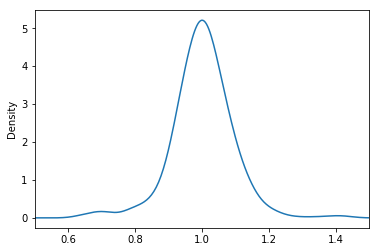

In [9]:
df_stations.flow_relative.plot.kde(xlim=(0.5,1.5))

In [10]:
map_stations(df_stations, 'flow_abs')